# Non-Centered Parameterization {#sec-non-centered-parameterization}

**Prerequisiti**

- Leggere [Hierarchical models and reparameterization](https://vasishth.github.io/bayescogsci/book/) [@nicenboim2021introduction].

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [1]:
# Importazioni dalla libreria standard
import os
import logging

# Importazioni di librerie di terze parti
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cmdstanpy
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
from cmdstanpy import CmdStanModel
import pingouin as pg
from sklearn.linear_model import LinearRegression
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# Configurazione
seed = sum(map(ord, "non_centered_parameterization"))  # Genera un seme basato sulla somma dei valori ASCII della stringa "linear_algebra"
rng = np.random.default_rng(seed=seed)  # Crea un generatore di numeri casuali con il seme specificato
sns.set_theme(palette="colorblind")  # Imposta il tema di Seaborn per grafici accessibili ai daltonici
az.style.use("arviz-darkgrid")  # Imposta lo stile dei grafici di ArviZ
%config InlineBackend.figure_format = "retina"  # Migliora la risoluzione dei grafici inline

# Definizione delle directory
home_directory = os.path.expanduser("~")  # Ottiene la directory home dell'utente
project_directory = f"{home_directory}/_repositories/psicometria"  # Definisce la directory del progetto

## Introduzione {.unnumbered}

Lo scopo di questo capitolo è spiegare il concetto di *Non-Centered Parameterization*.

In un modello di regressione bivariata, l'obiettivo è stimare una relazione lineare tra due variabili: ad esempio, l'altezza ($y$) e il peso ($x$) di un campione di persone adulte. Supponiamo di avere una relazione del tipo:

$$
y_i = \alpha + \beta x_i + \epsilon_i,
$$

dove:

- $y_i$ è l'altezza dell'individuo $i$,
- $x_i$ è il peso dell'individuo $i$ (espresso come differenze dalla media per migliorare l'interpretabilità),
- $\alpha$ è l'intercetta,
- $\beta$ è il coefficiente di regressione,
- $\epsilon_i$ è l'errore residuo, spesso assunto distribuito secondo una normale con media zero e varianza $\sigma^2$.

## Un Esempio Concreto

Per fare un esempio, applicheremo il modello di regressione bivariato alla relazione tra altezza e peso. I dati contenuti nel file *Howell_18.csv* sono parte di un censimento parziale della popolazione !Kung San dell'area di Dobe, raccolti tramite interviste condotte da Nancy Howell alla fine degli anni '60 [@McElreath_rethinking]. I !Kung San sono una delle popolazioni di raccoglitori-cacciatori più conosciute del ventesimo secolo e sono stati oggetto di numerosi studi antropologici. In questa analisi, consideriamo un sottocampione di dati relativi alla popolazione adulta (di età superiore ai 18 anni).

In [3]:
# Definire il percorso del file CSV
file_path = os.path.join(project_directory, "data", "Howell_18.csv")

# Leggere il file CSV in un DataFrame pandas
df = pd.read_csv(file_path)
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


Esaminiamo la relazione tra altezza e peso con un diagramma a dispersione.

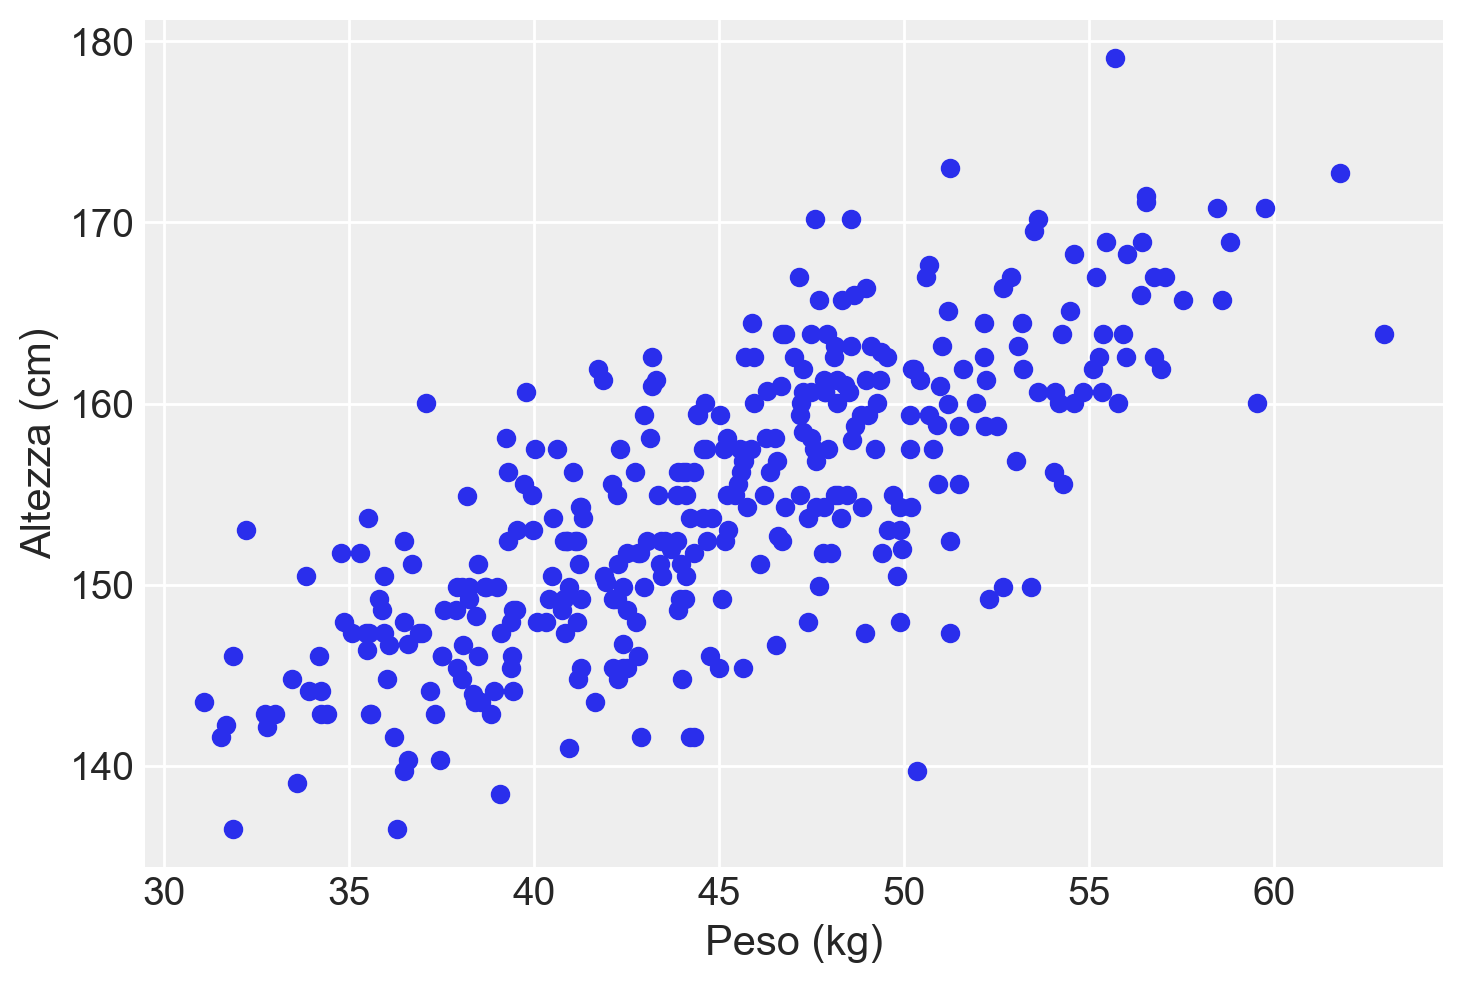

In [4]:
plt.scatter(
    df["weight"],
    df["height"]
)
plt.xlabel("Peso (kg)")
plt.ylabel("Altezza (cm)")
plt.show()

Per facilitare l'analisi successiva, centriamo la variabile $X$ (peso) in modo tale che l'intercetta del modello di regressione corrisponda all'altezza prevista degli individui con un peso medio.

In [5]:
df["weight_c"] = df["weight"] - np.mean(df["weight"])

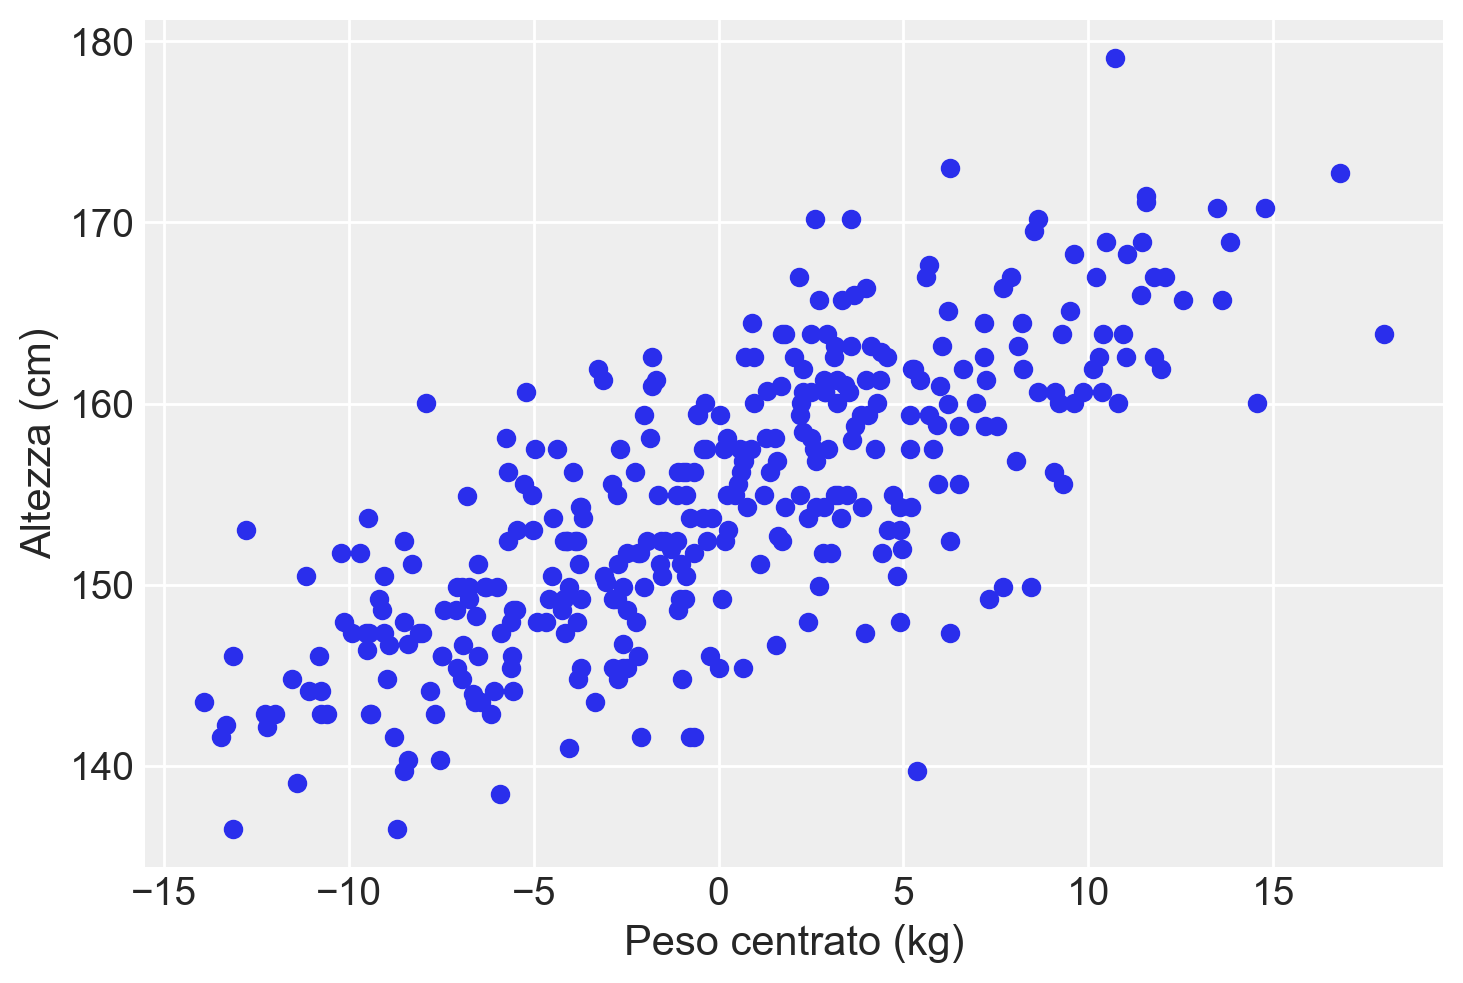

In [6]:
plt.scatter(
    df["weight_c"],
    df["height"]
)
plt.xlabel("Peso centrato (kg)")
plt.ylabel("Altezza (cm)")
plt.show()

Eseguiamo l'analisi di regressione con l'approccio della massima verosimiglianza.

In [7]:
lm = pg.linear_regression(df["weight_c"], df["height"])
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,154.60,0.27,570.25,0.0,0.57,0.57,154.06,155.13
1,weight_c,0.91,0.04,21.52,0.0,0.57,0.57,0.82,0.99


## Prima Versione del Modello: Utilizzo dei Dati Grezzi

In una priva versione del modello Stan, stimeremo i parametri del modello di regressione direttamente dai dati grezzi. Quando modelliamo direttamente sui dati grezzi, il modello in Stan ha la forma seguente.

In [8]:
stan_file = os.path.join(project_directory, "stan", "howell_model.stan")
model_raw = CmdStanModel(stan_file=stan_file)
print(model_raw.code())

data {
  int<lower=0> N; // numero di osservazioni
  vector[N] x; // pesi (differenze dalla media)
  vector[N] y; // altezze
}
parameters {
  real alpha; // intercetta
  real beta; // coefficiente di regressione
  real<lower=0> sigma; // deviazione standard dell'errore
}
model {
  // Priors
  alpha ~ normal(154, 10); // prior per l'intercetta
  beta ~ normal(0, 5); // prior per il coefficiente di regressione
  sigma ~ cauchy(0, 5); // prior per la deviazione standard
  
  // Likelihood
  y ~ normal(alpha + beta * x, sigma);
}



Si osservi che, in questa prima istanziazione del modello bayesiano, abbiamo specificato le seguenti distribuzioni a priori per i parametri del modello:

```stan
alpha ~ normal(154, 10); // prior per l'intercetta
beta ~ normal(0, 5); // prior per il coefficiente di regressione
sigma ~ cauchy(0, 5); // prior per la deviazione standard
```

Sistemiamo i dati in un dizionario come richiesto dal modello Stan.

In [9]:
stan_data = {"N": len(df["height"]), "x": df["weight_c"], "y": df["height"]}

Eseguiamo il campionamento MCMC.

In [10]:
fit_raw = model_raw.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

Esaminiamo le distribuzioni a posteriori dei parametri.

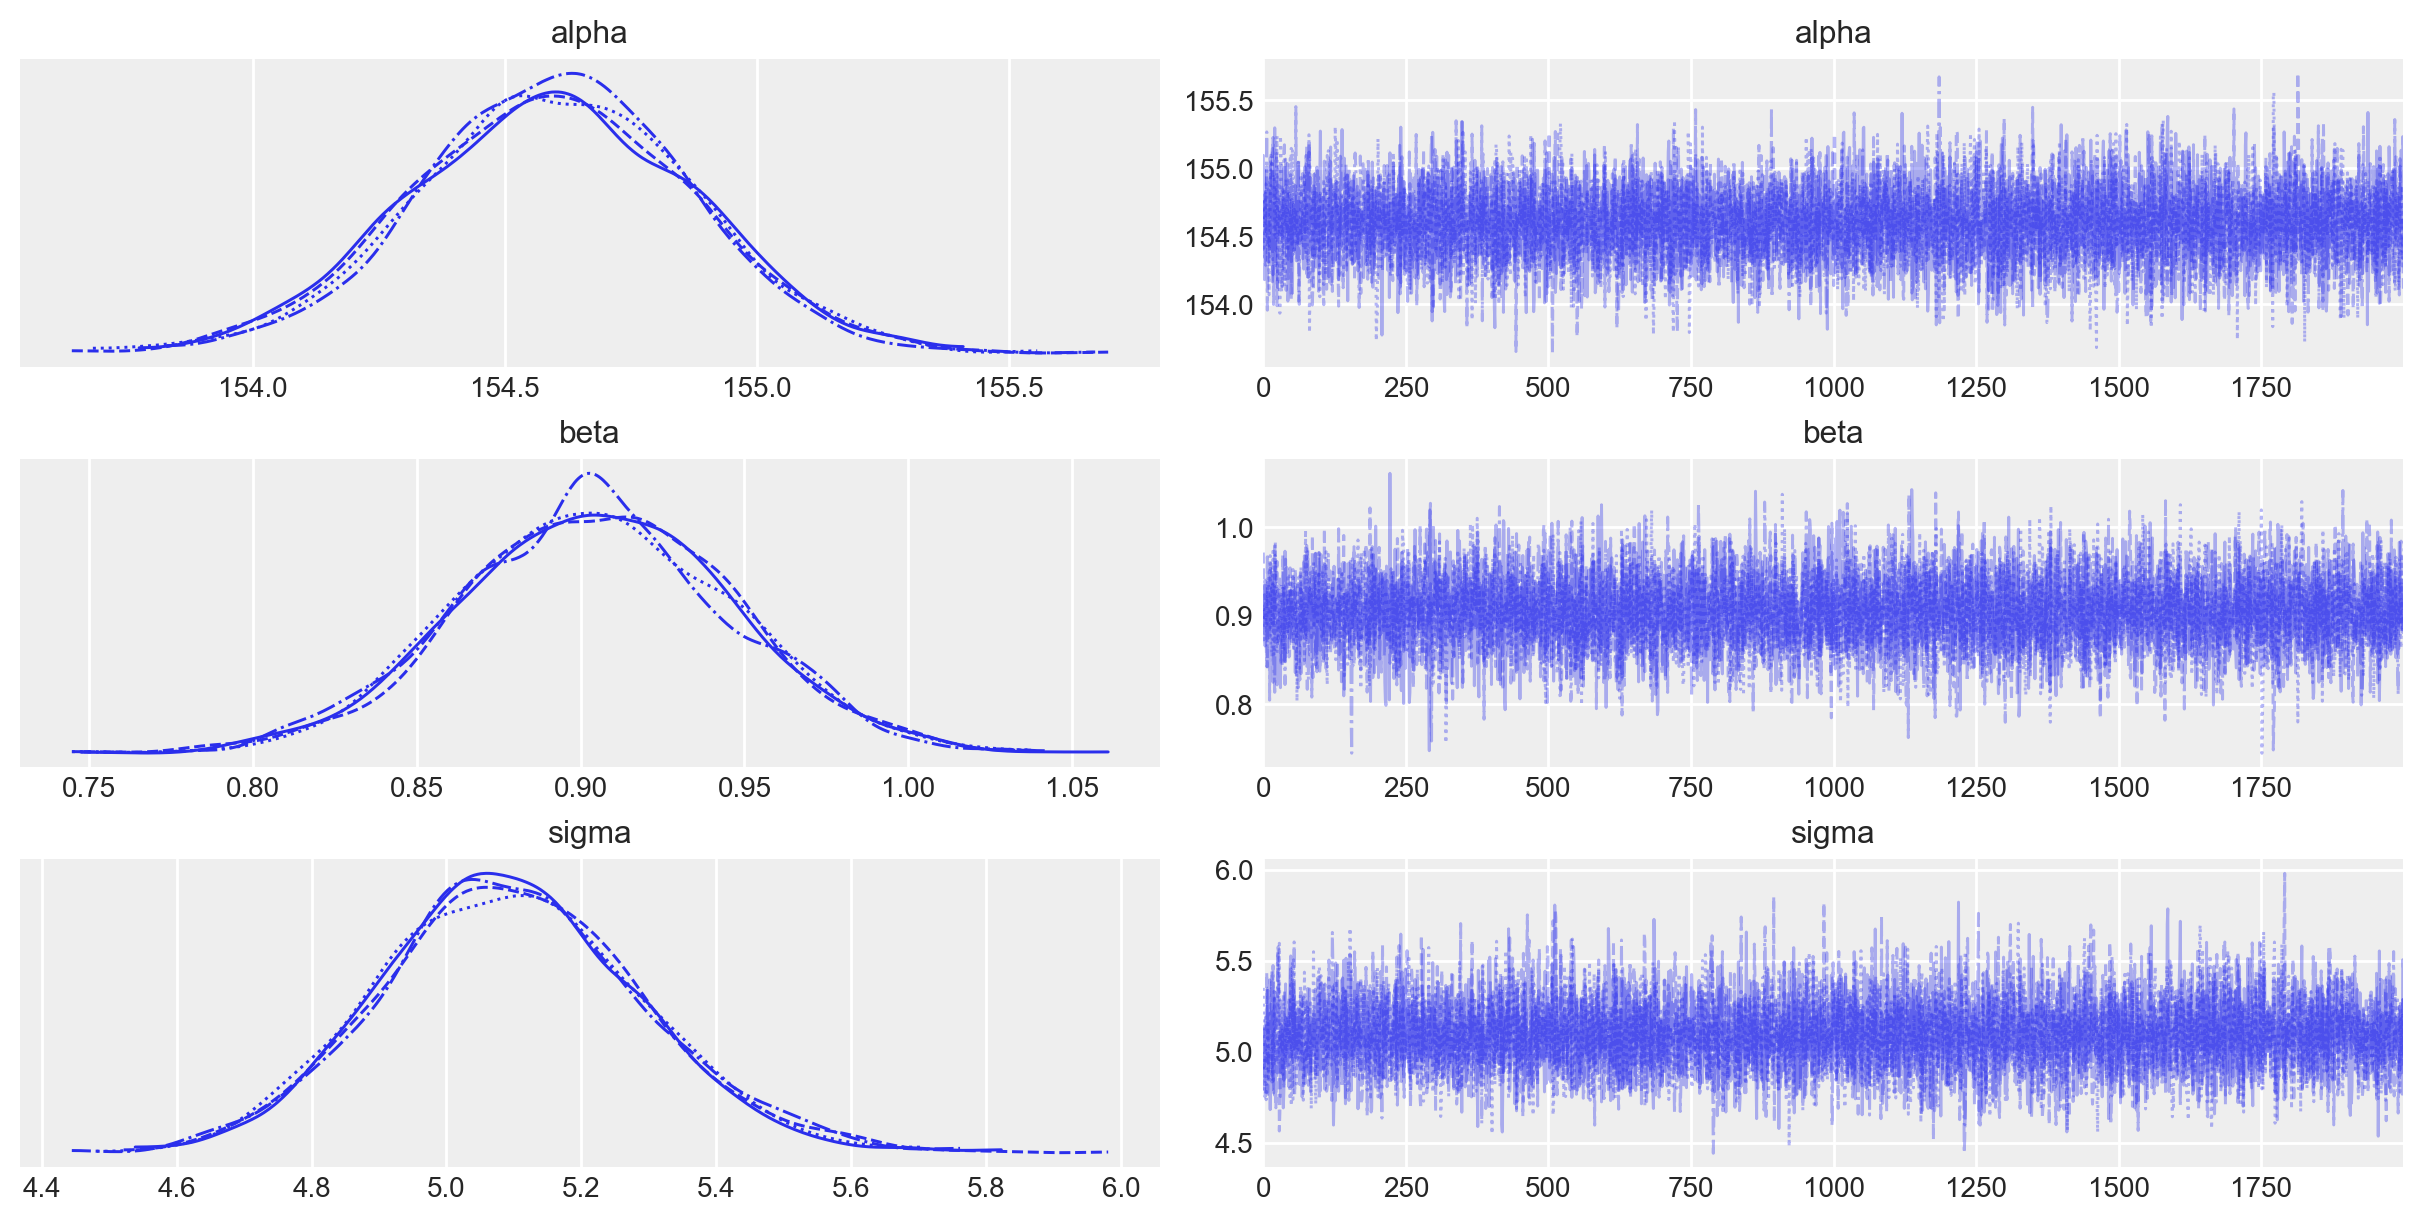

In [11]:
_ = az.plot_trace(fit_raw, var_names=(["alpha", "beta", "sigma"]))

Procediamo quindi con l'esame di un sommario delle distribuzioni a posteriori dei parametri del modello lineare.

In [12]:
az.summary(fit_raw, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,154.596,0.274,154.086,155.115,0.003,0.002,8561.0,5960.0,1.0
beta,0.904,0.042,0.824,0.980,0.000,0.000,7766.0,6003.0,1.0
sigma,5.096,0.193,4.745,5.471,0.002,0.002,7739.0,5899.0,1.0


Avendo usato dei prior debolmente informativi, le medie delle distribuzioni a posteriori dei parametri del modello replicano sostanzialmente i risultati ottenuti con il metodo della massima verosimiglianza.

## Seconda Versione del Modello: Non-Centered Parameterization

In una seconda versione del modello Stan usiamo la *Non-Centered Parameterization*.

La *Non-Centered Parameterization* (NCP) è una tecnica utilizzata per migliorare la convergenza dei modelli Bayesiani, specialmente quando i dati sono correlati o quando ci sono differenze di scala tra i parametri. È particolarmente utile nei modelli gerarchici, ma può essere applicata anche a modelli semplici come quello che stiamo considerando.

### Cosa Significa Non-Centered Parameterization?

In una parametrizzazione classica ("centered"), i parametri sono direttamente campionati dallo spazio dei dati. Tuttavia, in una "non-centered parameterization", riformuliamo il modello per campionare da uno spazio trasformato (solitamente standardizzato) e poi mappiamo questi campioni indietro allo spazio originale dei dati. Questo aiuta a evitare problemi di convergenza che possono sorgere quando il posteriori dei parametri ha forme non gaussiane o quando i dati presentano varianza su scale diverse.

### Come si Realizza la Non-Centered Parameterization?

Nel contesto del modello di regressione bivariato, la NCP può essere implementata introducendo parametri ausiliari che trasformano i parametri del modello in uno spazio con prior standardizzati.

In [13]:
stan_file = os.path.join(project_directory, "stan", "howell_ncp_model.stan")
model_ncp = CmdStanModel(stan_file=stan_file)
print(model_ncp.code())

data {
  int<lower=0> N; // numero di osservazioni
  vector[N] x; // pesi (differenze dalla media)
  vector[N] y; // altezze
}
parameters {
  real alpha_tilde; // parametro ausiliario per l'intercetta
  real beta_tilde; // parametro ausiliario per il coefficiente di regressione
  real<lower=0> sigma; // deviazione standard dell'errore
}
transformed parameters {
  real alpha; // intercetta
  real beta; // coefficiente di regressione
  
  // Trasformazioni per ottenere i parametri nella scala dei dati grezzi
  alpha = 154 + 10 * alpha_tilde;
  beta = 0 + 5 * beta_tilde;
}
model {
  // Priors standardizzati per i parametri ausiliari
  alpha_tilde ~ normal(0, 1); // prior standardizzato per alpha_tilde
  beta_tilde ~ normal(0, 1); // prior standardizzato per beta_tilde
  sigma ~ cauchy(0, 5); // prior per la deviazione standard
  
  // Likelihood sulla scala dei dati grezzi
  y ~ normal(alpha + beta * x, sigma);
}



In questo modello NCP:

- **Parametri Ausiliari Standardizzati**:
  - `alpha_tilde ~ normal(0, 1)` significa che $\alpha\_tilde$ è campionato da una distribuzione normale standardizzata con media 0 e deviazione standard 1.
  - `beta_tilde ~ normal(0, 1)` significa che $\beta\_tilde$ è campionato da una distribuzione normale standardizzata con media 0 e deviazione standard 1.

- **Trasformazioni per Ottenere $\alpha$ e $\beta$ sulla Scala dei Dati Grezzi**:

  - **$\alpha$**: viene trasformato utilizzando il prior originale $N(154, 10)$. Qui, $\alpha = 154 + 10 \cdot \alpha_{\text{tilde}}$. Questo riproduce esattamente il prior $N(154, 10)$ perché:
    $$
    \alpha \sim 154 + 10 \cdot N(0, 1) \equiv N(154, 10).
    $$
  - **$\beta$**: viene trasformato utilizzando il prior originale $N(0, 5)$. Qui, $\beta = 0 + 5 \cdot \beta_{\text{tilde}}$. Questo riproduce esattamente il prior $N(0, 5)$ perché:
    $$
    \beta \sim 0 + 5 \cdot N(0, 1) \equiv N(0, 5).
    $$

Eseguiamo il campionamento.

In [14]:
fit_ncp = model_ncp.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo le distribuzioni a posteriori dei parametri.

In [15]:
az.summary(fit_ncp, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,154.594,0.275,154.084,155.108,0.003,0.002,9429.0,5648.0,1.0
beta,0.905,0.042,0.826,0.985,0.000,0.000,10014.0,6195.0,1.0
sigma,5.099,0.191,4.742,5.451,0.002,0.001,8848.0,6357.0,1.0


Si noti che le statistiche riassuntive delle distribuzioni a posteriori dei parametri riproducono i risultati trovati in precedenza con la parametrizzazione "centered".

## Considerazioni Conclusive

La NCP può migliorare la convergenza e l'efficienza del campionamento, specialmente in modelli con forti correlazioni tra i parametri o quando i dati presentano diverse scale. In questo caso specifico, applicare la NCP non è cruciale a causa della relativa semplicità del modello, ma è comunque una buona pratica da imparare e applicare, specialmente in contesti più complessi.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -m  

Last updated: Mon Sep 16 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 24.0.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

statsmodels: 0.14.2
matplotlib : 3.9.1
cmdstanpy  : 1.2.4
numpy      : 1.26.4
pingouin   : 0.5.4
seaborn    : 0.13.2
pandas     : 2.2.2
arviz      : 0.18.0
logging    : 0.5.1.2

